# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [24]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), 
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Resize(28)])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST("data/TrainingSet", train = True, 
                                           download = True, transform = transform)

train, valid = random_split(train_data, [50000, 10000])

training_dataloader = DataLoader(train, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(valid, batch_size = 32, shuffle = True)
# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST("data/TestingSet", train = False, 
                                       download = True, transform = transform)

testing_dataloader = DataLoader(test_data, batch_size = 32)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Based on the provided MNIST Resource, I have checked that most Neural Net models didn't require a preprocessing because the data is already written in different patterns and has been size-normalized, so I only converted the images to tensors**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

**In order to visualize Images I removed normalization from the transforms**

0


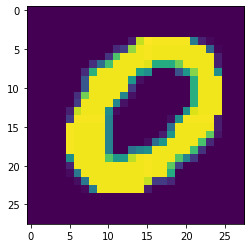

4


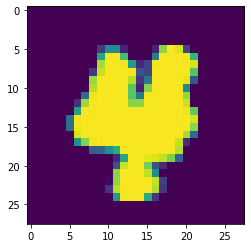

3


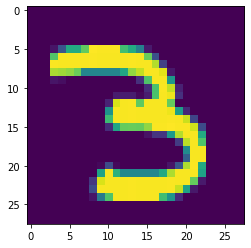

5


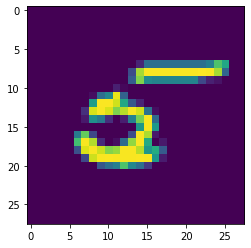

6


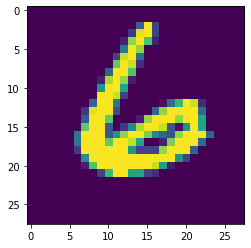

In [7]:
# Explore data
show5(validation_dataloader)

6


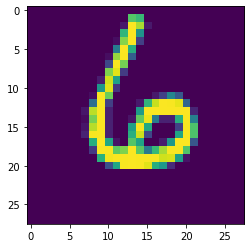

5


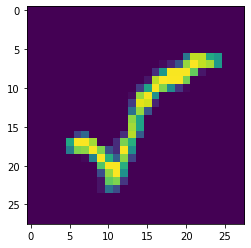

8


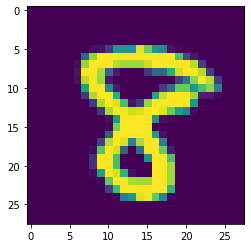

0


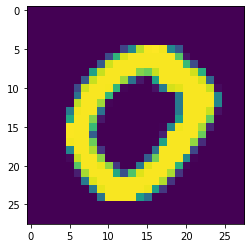

3


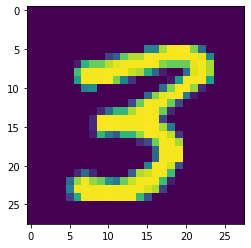

In [8]:
# Explore data
show5(training_dataloader)

7


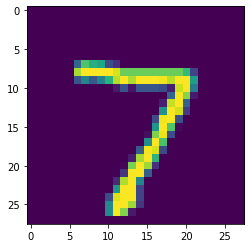

2


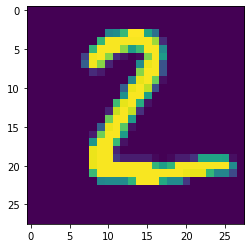

1


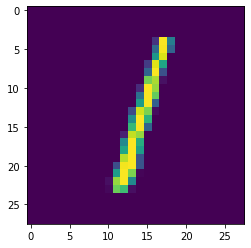

0


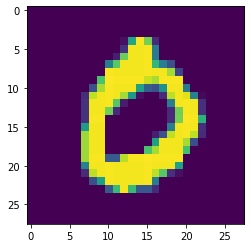

4


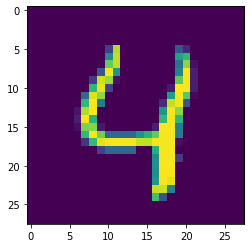

In [9]:
show5(testing_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.softmax
        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
def early_stopping(train_loss, validation_loss, min_delta, patience):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

In [13]:
num_epochs = 15

# Establishing a list for train/val loss history
train_loss_history = list()
val_loss_history = list()

threshold = 0.01
patience = 2

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(training_dataloader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(training_dataloader):.2f}% training loss: {train_loss/len(training_dataloader):.5f}')
    train_loss_history.append(train_loss/len(training_dataloader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in validation_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(validation_dataloader):.2f}% validation loss: {val_loss/len(validation_dataloader):.5f}')
    val_loss_history.append(val_loss/len(validation_dataloader))
    if (True == early_stopping(train_loss, val_loss, threshold, patience)):
        break;
    

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 1 training accuracy: 0.58% training loss: 1.80204
Epoch 1 validation accuracy: 0.76% validation loss: 1.02711
Epoch 2 training accuracy: 0.77% training loss: 0.75493
Epoch 2 validation accuracy: 0.78% validation loss: 0.61312
Epoch 3 training accuracy: 0.78% training loss: 0.56902
Epoch 3 validation accuracy: 0.79% validation loss: 0.53913
Epoch 4 training accuracy: 0.81% training loss: 0.51123
Epoch 4 validation accuracy: 0.83% validation loss: 0.48991
Epoch 5 training accuracy: 0.84% training loss: 0.44985
Epoch 5 validation accuracy: 0.85% validation loss: 0.43746
Epoch 6 training accuracy: 0.85% training loss: 0.40828
Epoch 6 validation accuracy: 0.85% validation loss: 0.41873
Epoch 7 training accuracy: 0.86% training loss: 0.38387
Epoch 7 validation accuracy: 0.87% validation loss: 0.39139
Epoch 8 training accuracy: 0.89% training loss: 0.35622
Epoch 8 validation accuracy: 0.90% validation loss: 0.35514
Epoch 9 training accuracy: 0.92% training loss: 0.30317
Epoch 9 validati

Plot the training loss (and validation loss/accuracy, if recorded).

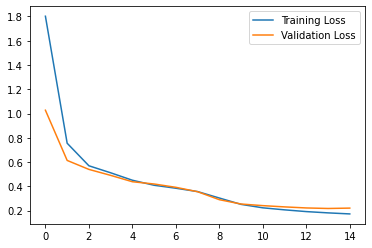

In [14]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
test_loss = 0.0
test_correct = 0
net.eval()
for inputs, labels in testing_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).float().mean().item()
print(f'Testing accuracy: {test_correct/len(testing_dataloader):.2f}%')

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Testing accuracy: 0.94%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.log_softmax
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [18]:
num_epochs = 10

# Establishing a list for train/val loss history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(training_dataloader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(training_dataloader):.2f}% training loss: {train_loss/len(training_dataloader):.5f}')
    train_loss_history.append(train_loss/len(training_dataloader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in testing_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(validation_dataloader):.2f}% validation loss: {val_loss/len(validation_dataloader):.5f}')
    val_loss_history.append(val_loss/len(validation_dataloader))
    if (True == early_stopping(train_loss, val_loss, threshold, patience)):
        break;

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 1 training accuracy: 0.86% training loss: 0.48856
Epoch 1 validation accuracy: 0.89% validation loss: 0.35586
Epoch 2 training accuracy: 0.90% training loss: 0.33356
Epoch 2 validation accuracy: 0.92% validation loss: 0.29006
Epoch 3 training accuracy: 0.91% training loss: 0.29768
Epoch 3 validation accuracy: 0.91% validation loss: 0.29167
Epoch 4 training accuracy: 0.92% training loss: 0.27780
Epoch 4 validation accuracy: 0.94% validation loss: 0.21541
Epoch 5 training accuracy: 0.93% training loss: 0.25977
Epoch 5 validation accuracy: 0.92% validation loss: 0.29204
Epoch 6 training accuracy: 0.93% training loss: 0.25119
Epoch 6 validation accuracy: 0.90% validation loss: 0.33991
Epoch 7 training accuracy: 0.93% training loss: 0.24010
Epoch 7 validation accuracy: 0.91% validation loss: 0.29250
Epoch 8 training accuracy: 0.94% training loss: 0.22799
Epoch 8 validation accuracy: 0.94% validation loss: 0.20910
Epoch 9 training accuracy: 0.93% training loss: 0.22702
Epoch 9 validati

In [19]:
test_loss = 0.0
test_correct = 0
net.eval()
for inputs, labels in testing_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).float().mean().item()
        test_loss += loss.item()
print(f'Testing accuracy: {test_correct/len(testing_dataloader):.2f}%')

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Testing accuracy: 0.94%


## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
torch.save(net, "Handwritten Digits Classifier")